In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 60214497.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define the CNN model with Sigmoid activation in all layers for CIFAR-10
class CNNSigmoidCIFAR10(nn.Module):
    def __init__(self):
        super(CNNSigmoidCIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the input size based on your input image dimensions
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))  # Apply Sigmoid to the output of the first convolutional layer
        x = self.pool(torch.sigmoid(self.conv2(x)))  # Apply Sigmoid to the output of the second convolutional layer
        x = self.pool(torch.sigmoid(self.conv3(x)))  # Apply Sigmoid to the output of the third convolutional layer
        x = x.view(-1, 128 * 4 * 4)  # Reshape before passing to fully connected layers
        x = torch.sigmoid(self.fc1(x))  # Apply Sigmoid to the output of the first fully connected layer
        x = self.fc2(x)
        return x


In [ ]:
# new code 1
# Choose a percentage of samples for the small dataset
small_dataset_percentage = 0.1  # You can adjust this value

small_train_size = int(small_dataset_percentage * len(train_dataset))
small_test_size = int(small_dataset_percentage * len(test_dataset))

# Create small subsets
small_train_dataset = torch.utils.data.Subset(train_dataset, range(small_train_size))
small_test_dataset = torch.utils.data.Subset(test_dataset, range(small_test_size))

# Create data loaders
small_train_loader = torch.utils.data.DataLoader(dataset=small_train_dataset, batch_size=64, shuffle=True)
small_test_loader = torch.utils.data.DataLoader(dataset=small_test_dataset, batch_size=64, shuffle=False)


Epoch [1/10], Train Accuracy: 0.1264, Test Accuracy: 0.1360
Epoch [2/10], Train Accuracy: 0.2462, Test Accuracy: 0.2700
Epoch [3/10], Train Accuracy: 0.2754, Test Accuracy: 0.2780
Epoch [4/10], Train Accuracy: 0.2976, Test Accuracy: 0.2970
Epoch [5/10], Train Accuracy: 0.3010, Test Accuracy: 0.3010
Epoch [6/10], Train Accuracy: 0.3056, Test Accuracy: 0.3190
Epoch [7/10], Train Accuracy: 0.3110, Test Accuracy: 0.3160
Epoch [8/10], Train Accuracy: 0.3460, Test Accuracy: 0.3580
Epoch [9/10], Train Accuracy: 0.3658, Test Accuracy: 0.3600
Epoch [10/10], Train Accuracy: 0.3932, Test Accuracy: 0.3660


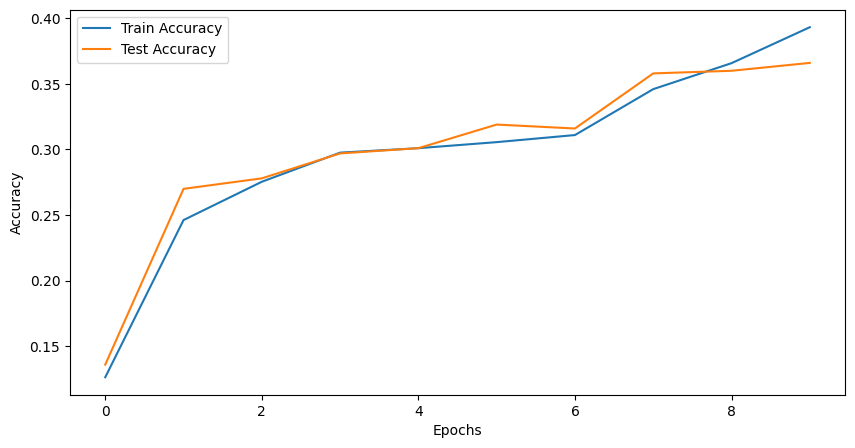

In [ ]:
#new code 2

# Instantiate the model
small_model = CNNSigmoidCIFAR10()
small_criterion = nn.CrossEntropyLoss()
small_optimizer = optim.Adam(small_model.parameters(), lr=0.001)

# Training the model on the small dataset
small_num_epochs = 10
small_train_losses = []
small_test_losses = []
small_train_accuracies = []
small_test_accuracies = []

for epoch in range(small_num_epochs):
    small_model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(small_train_loader):
        # Forward pass
        small_outputs = small_model(images)
        small_loss = small_criterion(small_outputs, labels)

        # Backward pass and optimization
        small_optimizer.zero_grad()
        small_loss.backward()
        small_optimizer.step()

    # Evaluate on the training set
    small_model.eval()
    small_train_preds = []
    small_train_labels = []
    with torch.no_grad():
        for images, labels in small_train_loader:
            small_outputs = small_model(images)
            _, small_train_predicted = torch.max(small_outputs.data, 1)
            small_train_preds.extend(small_train_predicted.numpy())
            small_train_labels.extend(labels.numpy())

    small_train_accuracy = accuracy_score(small_train_labels, small_train_preds)
    small_train_losses.append(small_loss.item())
    small_train_accuracies.append(small_train_accuracy)

    # Evaluate on the test set
    small_test_preds = []
    small_test_labels = []
    with torch.no_grad():
        for images, labels in small_test_loader:
            small_outputs = small_model(images)
            _, small_test_predicted = torch.max(small_outputs.data, 1)
            small_test_preds.extend(small_test_predicted.numpy())
            small_test_labels.extend(labels.numpy())

    small_test_accuracy = accuracy_score(small_test_labels, small_test_preds)
    small_test_loss = small_criterion(small_outputs, labels).item()
    small_test_losses.append(small_test_loss)
    small_test_accuracies.append(small_test_accuracy)

    # Print training statistics
    print('Epoch [{}/{}], Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch + 1, small_num_epochs, small_train_accuracy, small_test_accuracy))

# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(small_train_accuracies, label='Train Accuracy')
plt.plot(small_test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


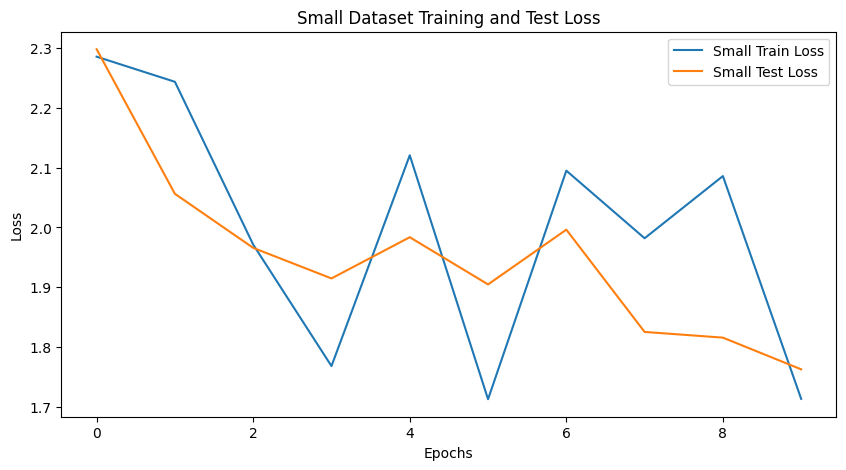

In [ ]:
# new code 3

# After the small dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(small_train_losses, label='Small Train Loss')
plt.plot(small_test_losses, label='Small Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Small Dataset Training and Test Loss')
plt.show()


In [ ]:
# new code 4
from sklearn.metrics import precision_score, recall_score, f1_score

# After the small dataset training loop
small_test_precision = precision_score(small_test_labels, small_test_preds, average='weighted')
small_test_recall = recall_score(small_test_labels, small_test_preds, average='weighted')
small_test_f1 = f1_score(small_test_labels, small_test_preds, average='weighted')

print("Small Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(small_test_accuracy))
print("Test Precision: {:.4f}".format(small_test_precision))
print("Test Recall: {:.4f}".format(small_test_recall))
print("Test F1 Score: {:.4f}".format(small_test_f1))


Small Dataset Metrics:
Test Accuracy: 0.3660
Test Precision: 0.3822
Test Recall: 0.3660
Test F1 Score: 0.3539


In [ ]:
# new code 5
# Load a large subset of the CIFAR-10 dataset
large_dataset_percentage = 0.7  # You can adjust this value

large_train_size = int(large_dataset_percentage * len(train_dataset))
large_test_size = int(large_dataset_percentage * len(test_dataset))

large_train_dataset = torch.utils.data.Subset(train_dataset, range(large_train_size))
large_test_dataset = torch.utils.data.Subset(test_dataset, range(large_test_size))

large_train_loader = torch.utils.data.DataLoader(dataset=large_train_dataset, batch_size=64, shuffle=True)
large_test_loader = torch.utils.data.DataLoader(dataset=large_test_dataset, batch_size=64, shuffle=False)

# Instantiate the model for the large dataset
large_model = CNNSigmoidCIFAR10()

# Define criterion and optimizer for the large dataset
large_criterion = nn.CrossEntropyLoss()
large_optimizer = optim.Adam(large_model.parameters(), lr=0.001)


Epoch [1/10], Large Train Accuracy: 0.3139, Large Test Accuracy: 0.3150
Epoch [2/10], Large Train Accuracy: 0.4275, Large Test Accuracy: 0.4330
Epoch [3/10], Large Train Accuracy: 0.4782, Large Test Accuracy: 0.4786
Epoch [4/10], Large Train Accuracy: 0.5087, Large Test Accuracy: 0.5054
Epoch [5/10], Large Train Accuracy: 0.5421, Large Test Accuracy: 0.5229
Epoch [6/10], Large Train Accuracy: 0.5626, Large Test Accuracy: 0.5399
Epoch [7/10], Large Train Accuracy: 0.5787, Large Test Accuracy: 0.5491
Epoch [8/10], Large Train Accuracy: 0.6100, Large Test Accuracy: 0.5634
Epoch [9/10], Large Train Accuracy: 0.6381, Large Test Accuracy: 0.5839
Epoch [10/10], Large Train Accuracy: 0.6579, Large Test Accuracy: 0.5879


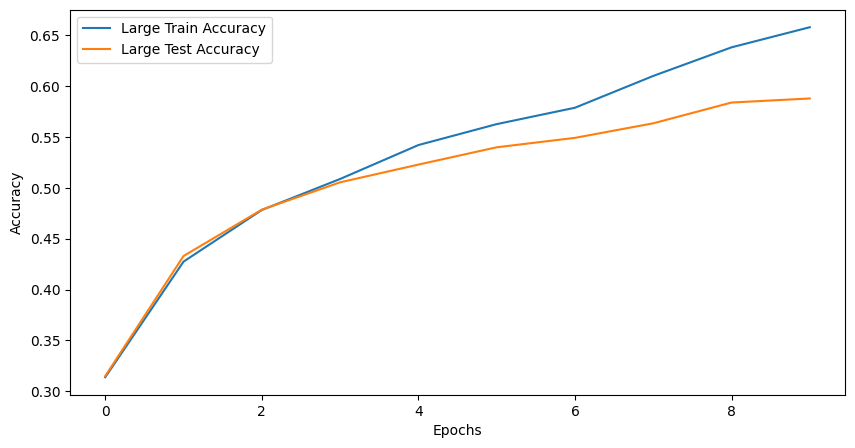

In [ ]:
#new code 6

# Training the model on the large dataset
large_num_epochs = 10
large_train_losses = []
large_test_losses = []
large_train_accuracies = []
large_test_accuracies = []

for epoch in range(large_num_epochs):
    large_model.train()
    for i, (images, labels) in enumerate(large_train_loader):
        large_outputs = large_model(images)
        large_loss = large_criterion(large_outputs, labels)
        large_optimizer.zero_grad()
        large_loss.backward()
        large_optimizer.step()

    # Evaluate on the training set
    large_model.eval()
    large_train_preds = []
    large_train_labels = []
    with torch.no_grad():
        for images, labels in large_train_loader:
            large_outputs = large_model(images)
            _, large_train_predicted = torch.max(large_outputs.data, 1)
            large_train_preds.extend(large_train_predicted.numpy())
            large_train_labels.extend(labels.numpy())

    large_train_accuracy = accuracy_score(large_train_labels, large_train_preds)
    large_train_losses.append(large_loss.item())
    large_train_accuracies.append(large_train_accuracy)

    # Evaluate on the test set
    large_test_preds = []
    large_test_labels = []
    with torch.no_grad():
        for images, labels in large_test_loader:
            large_outputs = large_model(images)
            _, large_test_predicted = torch.max(large_outputs.data, 1)
            large_test_preds.extend(large_test_predicted.numpy())
            large_test_labels.extend(labels.numpy())

    large_test_accuracy = accuracy_score(large_test_labels, large_test_preds)
    large_test_loss = large_criterion(large_outputs, labels).item()
    large_test_losses.append(large_test_loss)
    large_test_accuracies.append(large_test_accuracy)

    print('Epoch [{}/{}], Large Train Accuracy: {:.4f}, Large Test Accuracy: {:.4f}'.format(epoch + 1, large_num_epochs, large_train_accuracy, large_test_accuracy))

# Plot training and test accuracies for the large dataset
plt.figure(figsize=(10, 5))
plt.plot(large_train_accuracies, label='Large Train Accuracy')
plt.plot(large_test_accuracies, label='Large Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


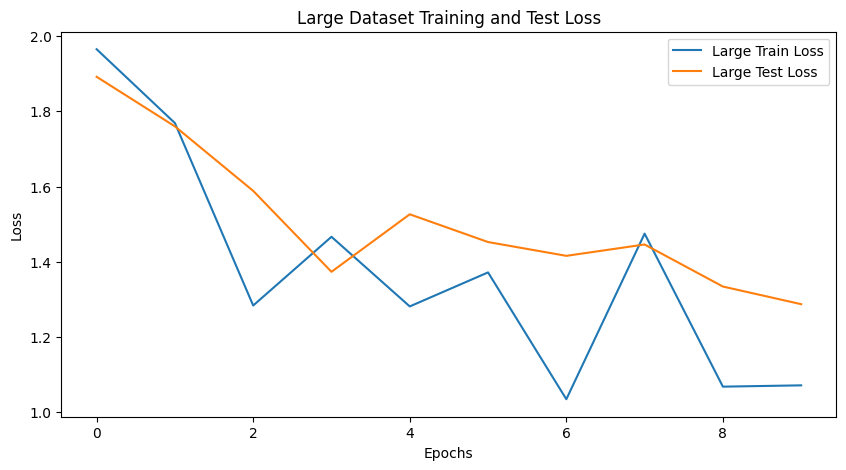

In [ ]:
# new code 7
# After the large dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(large_train_losses, label='Large Train Loss')
plt.plot(large_test_losses, label='Large Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Large Dataset Training and Test Loss')
plt.show()


In [ ]:
# new code 8
from sklearn.metrics import precision_score, recall_score, f1_score

# After the large dataset training loop
large_test_precision = precision_score(large_test_labels, large_test_preds, average='weighted')
large_test_recall = recall_score(large_test_labels, large_test_preds, average='weighted')
large_test_f1 = f1_score(large_test_labels, large_test_preds, average='weighted')

print("Large Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(large_test_accuracy))
print("Test Precision: {:.4f}".format(large_test_precision))
print("Test Recall: {:.4f}".format(large_test_recall))
print("Test F1 Score: {:.4f}".format(large_test_f1))


Large Dataset Metrics:
Test Accuracy: 0.5879
Test Precision: 0.5913
Test Recall: 0.5879
Test F1 Score: 0.5864


In [ ]:
# new code 9
# Instantiate the model for the full dataset
full_model = CNNSigmoidCIFAR10()

# Define criterion and optimizer for the full dataset
full_criterion = nn.CrossEntropyLoss()
full_optimizer = optim.Adam(full_model.parameters(), lr=0.001)



Epoch [1/10], Full Train Accuracy: 0.3584, Full Test Accuracy: 0.3656
Epoch [2/10], Full Train Accuracy: 0.4563, Full Test Accuracy: 0.4565
Epoch [3/10], Full Train Accuracy: 0.5195, Full Test Accuracy: 0.5115
Epoch [4/10], Full Train Accuracy: 0.5533, Full Test Accuracy: 0.5445
Epoch [5/10], Full Train Accuracy: 0.5899, Full Test Accuracy: 0.5648
Epoch [6/10], Full Train Accuracy: 0.6168, Full Test Accuracy: 0.5929
Epoch [7/10], Full Train Accuracy: 0.6243, Full Test Accuracy: 0.5909
Epoch [8/10], Full Train Accuracy: 0.6705, Full Test Accuracy: 0.6214
Epoch [9/10], Full Train Accuracy: 0.6769, Full Test Accuracy: 0.6197
Epoch [10/10], Full Train Accuracy: 0.6912, Full Test Accuracy: 0.6283


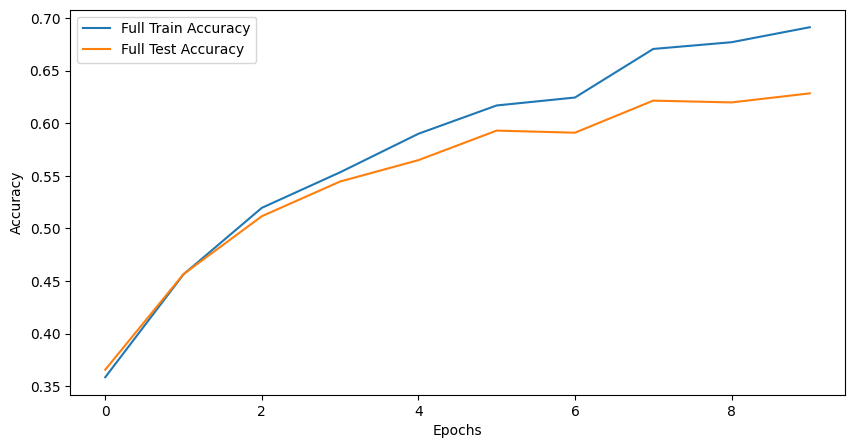

In [ ]:
# new code 10
# Training the model on the full dataset
full_num_epochs = 10
full_train_losses = []
full_test_losses = []
full_train_accuracies = []
full_test_accuracies = []

for epoch in range(full_num_epochs):
    full_model.train()
    for i, (images, labels) in enumerate(train_loader):
        full_outputs = full_model(images)
        full_loss = full_criterion(full_outputs, labels)
        full_optimizer.zero_grad()
        full_loss.backward()
        full_optimizer.step()

    # Evaluate on the training set
    full_model.eval()
    full_train_preds = []
    full_train_labels = []
    full_train_loss = 0.0
    with torch.no_grad():
        for images, labels in train_loader:
            full_outputs = full_model(images)
            _, full_train_predicted = torch.max(full_outputs.data, 1)
            full_train_preds.extend(full_train_predicted.numpy())
            full_train_labels.extend(labels.numpy())
            full_train_loss += full_criterion(full_outputs, labels).item()

    full_train_accuracy = accuracy_score(full_train_labels, full_train_preds)
    full_train_loss /= len(train_loader)  # Average over all batches
    full_train_losses.append(full_train_loss)
    full_train_accuracies.append(full_train_accuracy)

    # Evaluate on the test set
    full_test_preds = []
    full_test_labels = []
    full_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            full_outputs = full_model(images)
            _, full_test_predicted = torch.max(full_outputs.data, 1)
            full_test_preds.extend(full_test_predicted.numpy())
            full_test_labels.extend(labels.numpy())
            full_test_loss += full_criterion(full_outputs, labels).item()

    full_test_accuracy = accuracy_score(full_test_labels, full_test_preds)
    full_test_loss /= len(test_loader)  # Average over all batches
    full_test_losses.append(full_test_loss)
    full_test_accuracies.append(full_test_accuracy)

    print('Epoch [{}/{}], Full Train Accuracy: {:.4f}, Full Test Accuracy: {:.4f}'.format(epoch + 1, full_num_epochs, full_train_accuracy, full_test_accuracy))

# Plot training and test accuracies for the full dataset
plt.figure(figsize=(10, 5))
plt.plot(full_train_accuracies, label='Full Train Accuracy')
plt.plot(full_test_accuracies, label='Full Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


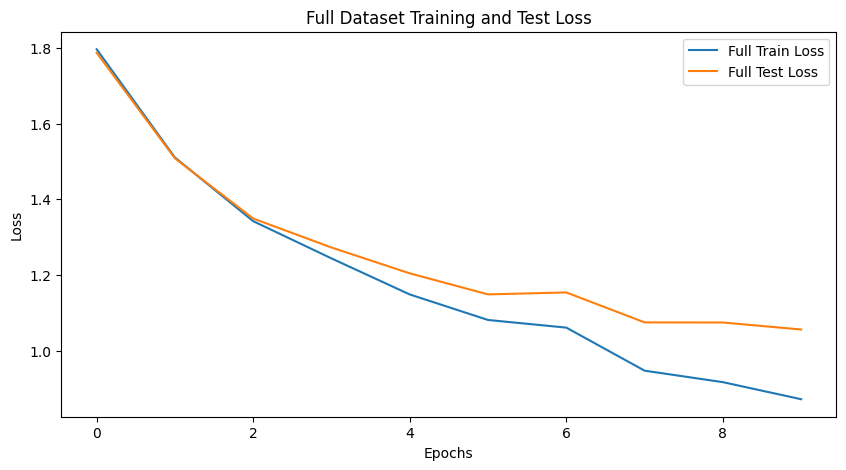

In [ ]:
# new code 11
# After the full dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(full_train_losses, label='Full Train Loss')
plt.plot(full_test_losses, label='Full Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Full Dataset Training and Test Loss')
plt.show()



In [ ]:
# new code 12
from sklearn.metrics import precision_score, recall_score, f1_score

# After the full dataset training loop
full_test_precision = precision_score(full_test_labels, full_test_preds, average='weighted')
full_test_recall = recall_score(full_test_labels, full_test_preds, average='weighted')
full_test_f1 = f1_score(full_test_labels, full_test_preds, average='weighted')

print("Full Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(full_test_accuracy))
print("Test Precision: {:.4f}".format(full_test_precision))
print("Test Recall: {:.4f}".format(full_test_recall))
print("Test F1 Score: {:.4f}".format(full_test_f1))


Full Dataset Metrics:
Test Accuracy: 0.6283
Test Precision: 0.6484
Test Recall: 0.6283
Test F1 Score: 0.6305


In [ ]:
# do not run
# Create an instance of the CNN model with Sigmoid activation for CIFAR-10
model_sigmoid_cifar10 = CNNSigmoidCIFAR10()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model_sigmoid_cifar10.parameters(), lr=0.001)  # Adam optimizer

# Training the model for CIFAR-10 with Sigmoid activation
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model_sigmoid_cifar10(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Test the model on CIFAR-10 test dataset with Sigmoid activation
model_sigmoid_cifar10.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model_sigmoid_cifar10(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model with Sigmoid activation in all layers for CIFAR-10: {:.2f} %'.format(100 * correct / total))


Epoch [1/10], Step [100/782], Loss: 2.2784
Epoch [1/10], Step [200/782], Loss: 2.0494
Epoch [1/10], Step [300/782], Loss: 2.0171
Epoch [1/10], Step [400/782], Loss: 1.9768
Epoch [1/10], Step [500/782], Loss: 1.7180
Epoch [1/10], Step [600/782], Loss: 1.7713
Epoch [1/10], Step [700/782], Loss: 1.7953
Epoch [2/10], Step [100/782], Loss: 1.8184
Epoch [2/10], Step [200/782], Loss: 1.6305
Epoch [2/10], Step [300/782], Loss: 1.5260
Epoch [2/10], Step [400/782], Loss: 1.6730
Epoch [2/10], Step [500/782], Loss: 1.4735
Epoch [2/10], Step [600/782], Loss: 1.6764
Epoch [2/10], Step [700/782], Loss: 1.4299
Epoch [3/10], Step [100/782], Loss: 1.2573
Epoch [3/10], Step [200/782], Loss: 1.4525
Epoch [3/10], Step [300/782], Loss: 1.4289
Epoch [3/10], Step [400/782], Loss: 1.1640
Epoch [3/10], Step [500/782], Loss: 1.4822
Epoch [3/10], Step [600/782], Loss: 1.3448
Epoch [3/10], Step [700/782], Loss: 1.2652
Epoch [4/10], Step [100/782], Loss: 1.2921
Epoch [4/10], Step [200/782], Loss: 1.5030
Epoch [4/10

In [ ]:
# Create an instance of the CNN model with Sigmoid activation for CIFAR-10
model_sigmoid_cifar10 = CNNSigmoidCIFAR10()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model_sigmoid_cifar10.parameters(), lr=0.001)  # Adam optimizer

Epoch [1/10], Training Accuracy (Sigmoid-CIFAR-10): 69.85%, Test Accuracy (Sigmoid-CIFAR-10): 64.20%
Epoch [2/10], Training Accuracy (Sigmoid-CIFAR-10): 71.83%, Test Accuracy (Sigmoid-CIFAR-10): 65.04%
Epoch [3/10], Training Accuracy (Sigmoid-CIFAR-10): 73.73%, Test Accuracy (Sigmoid-CIFAR-10): 64.70%
Epoch [4/10], Training Accuracy (Sigmoid-CIFAR-10): 75.37%, Test Accuracy (Sigmoid-CIFAR-10): 66.37%
Epoch [5/10], Training Accuracy (Sigmoid-CIFAR-10): 77.05%, Test Accuracy (Sigmoid-CIFAR-10): 66.11%
Epoch [6/10], Training Accuracy (Sigmoid-CIFAR-10): 78.54%, Test Accuracy (Sigmoid-CIFAR-10): 67.29%
Epoch [7/10], Training Accuracy (Sigmoid-CIFAR-10): 80.08%, Test Accuracy (Sigmoid-CIFAR-10): 67.12%
Epoch [8/10], Training Accuracy (Sigmoid-CIFAR-10): 81.65%, Test Accuracy (Sigmoid-CIFAR-10): 66.52%
Epoch [9/10], Training Accuracy (Sigmoid-CIFAR-10): 83.23%, Test Accuracy (Sigmoid-CIFAR-10): 67.92%
Epoch [10/10], Training Accuracy (Sigmoid-CIFAR-10): 84.65%, Test Accuracy (Sigmoid-CIFAR-1

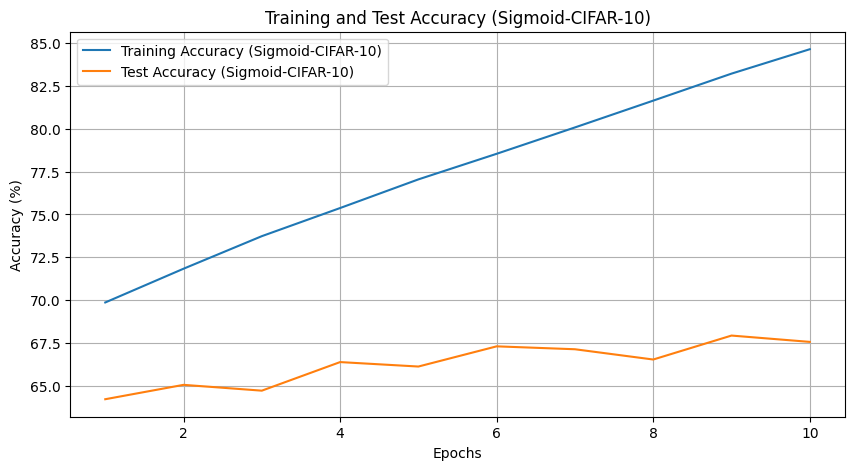

In [ ]:
import matplotlib.pyplot as plt
# Lists to store training and test accuracies
train_accuracies_sigmoid_cifar10 = []
test_accuracies_sigmoid_cifar10 = []

# Training the model for CIFAR-10 with Sigmoid activation
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    train_correct = 0
    train_total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model_sigmoid_cifar10(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies_sigmoid_cifar10.append(train_accuracy)

    # Test the model for CIFAR-10 with Sigmoid activation
    model_sigmoid_cifar10.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_sigmoid_cifar10(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies_sigmoid_cifar10.append(test_accuracy)

    print('Epoch [{}/{}], Training Accuracy (Sigmoid-CIFAR-10): {:.2f}%, Test Accuracy (Sigmoid-CIFAR-10): {:.2f}%'.format(epoch+1, num_epochs, train_accuracy, test_accuracy))

# Plotting the accuracies for Sigmoid activation in CIFAR-10
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies_sigmoid_cifar10, label='Training Accuracy (Sigmoid-CIFAR-10)')
plt.plot(range(1, num_epochs + 1), test_accuracies_sigmoid_cifar10, label='Test Accuracy (Sigmoid-CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy (Sigmoid-CIFAR-10)')
plt.legend()
plt.grid(True)
plt.show()
